In [16]:
%cd '/home/danbi/userdata/DANBI/gugakwon/Yeominrak'
%load_ext autoreload
%autoreload 2

/home/danbi/userdata/DANBI/gugakwon/Yeominrak
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch
from collections import defaultdict, Counter
import copy
import numpy as np
from model import Seq2seq
import random as random

from torch.nn.utils.rnn import pack_sequence, PackedSequence, pad_packed_sequence, pack_padded_sequence

In [18]:
file_path = Path('/home/danbi/userdata/DANBI/gugakwon/Yeominrak/yeominrak_data')
file_list = sorted(list(file_path.glob('*.musicxml')))

In [19]:
class Gnote:
    def __init__(self, note: music21.note.Note, part_idx:int) -> None:
        self.note = [note]  

        self.pitch = note.pitch.ps
        self.tie = note.tie
        self.part_idx = part_idx
        if part_idx == 0:
            self.pitch -= (9+12) # C4 -> EB2
        self.measure_number = note.measureNumber
        self.offset = note.offset
        self.measure_offset = 0.0 # dummy value, float로 함!(offset: float)
        # self.dynamic = 0.0
        
    def __add__(self, note: music21.note.Note):
        # assert self.pitch == note.pitch.ps
        self.note.append(note)
        return self

    @property
    def duration(self):
        return sum([note.duration.quarterLength for note in self.note])

    @property
    def end_measure_number(self):
        return self.note[-1].measureNumber
    
    @property
    def dynamic(self):
            # note_measure_offset = note.offset - self.parts[part_idx].measure_offsets[measure_idx]
        if self.part_idx == 0:
            # 세종실록악보 : 2.5/1.5, 1.5/1/1.5
            dynamic_mapping = {0.0: 'strong', 2.5: 'strong', 1.5: 'middle'}
        
        elif self.part_idx == 1:
            # 금합자보: 5/3, 3/2/3
            dynamic_mapping = {0.0: 'strong', 5.0: 'strong', 3.0: 'middle'}
        
        elif self.part_idx in [2, 3, 4, 5]:
            # 속악원보, 금보신증가령, 한금신보, 어은보: 6/4, 3/3/2/2 
            dynamic_mapping = {0.0: 'strong', 6.0: 'strong', 3.0: 'middle', 8.0: 'middle'}
        
        elif self.part_idx in [6, 7]:
            # 삼죽금보, 현행: 5/5, 3/2/2/3
            dynamic_mapping = {0.0: 'strong', 5.0: 'strong', 3.0: 'middle', 7.0: 'middle'}
        else:
            raise ValueError(f'Unknown part_idx: {self.part_idx}')
        
        return dynamic_mapping.get(self.measure_offset, 'weak')
    
    def __repr__(self) -> str:
        return f'Gnote: {self.pitch}, {self.duration}, {self.measure_offset}, {self.dynamic}'

    def to_tensor(self):
        return 



def apply_tie(notes: List[music21.note.Note], part_idx) -> List[music21.note.Note]:
    tied_notes = []
    for note in notes:
        if note.tie is not None:
            if note.tie.type == 'start':
                tied_notes.append(Gnote(note, part_idx))
            elif note.tie.type == 'continue':
                tied_notes[-1] +=  note
            elif note.tie.type == 'stop':
                tied_notes[-1] += note
            else:
                raise ValueError(f'Unknown tie type: {note.tie.type}')
        else:
            tied_notes.append(Gnote(note, part_idx))
    # print(tied_notes)
    return tied_notes


In [20]:
class Part:
    def __init__(self, part: music21.stream.base.Part, part_idx) -> None:
        self.part = part
        self.time_signature = None
        
        
        self.flattened_notes = [note for note in self.part.flat.notes if note.duration.isGrace == False]
        
        self.num_measures = self.flattened_notes[-1].measureNumber - self.flattened_notes[0].measureNumber + 1
        self.measures = [ [] for _ in range(self.num_measures) ]
        
        self.tie_cleaned_notes = apply_tie(self.flattened_notes, part_idx)
        for note in self.tie_cleaned_notes:
            self.measures[note.measure_number-1].append(note)
        # print(self.measures[0])
        self.measure_duration = self.get_measure_duration()
        self.measure_offsets = [i * self.measure_duration for i in range(self.num_measures)]
        # print(self.measure_offsets)
        self.repair_measure_offset_and_dynamic()
        
        # for note in self.flattened_notes:
        #     self.measures[note.measureNumber-1].append(note)


    # def repair_measure_offset(self):
    #     # repair offset of self.measures using self.measure_offsets
    #     for i, measure in enumerate(self.measures):
    #         measure_offset = self.measure_offsets[i]
    #         # print(measure_offset)
    #         for gnote in measure:
    #             gnote_measure = gnote.note[0].getContextByClass(stream.Measure, sortByCreationTime=True)
    #             recorded_music21_measure_offset = gnote_measure.offset
    #             if measure_offset != recorded_music21_measure_offset:
    #                 gnote.offset += measure_offset - recorded_music21_measure_offset
            
                    # print(gnote.offset)

    
    def repair_measure_offset_and_dynamic(self):
        # repair offset of self.measures using self.measure_offsets
        for i, measure in enumerate(self.measures):
            measure_offset = self.measure_offsets[i]
            for gnote in measure:
                gnote_measure = gnote.note[0].getContextByClass(stream.Measure, sortByCreationTime=True)
                recorded_music21_measure_offset = gnote_measure.offset
                if measure_offset != recorded_music21_measure_offset:
                    gnote.offset += measure_offset - recorded_music21_measure_offset
                gnote.measure_offset = gnote.offset - measure_offset
                # gnote.dynamic = gnote.dynamic
                
    def __len__(self):
        return len(self.measures)

    def get_measure_duration(self):
        # print(self.measures[0])
        durations =  [sum([note.duration for note in measure]) for measure in self.measures]
        # print(durations)
        most_common_duration = Counter(durations).most_common(1)[0][0]
        return most_common_duration
    
    def convert_to_common_beat(self):
        common_measures = []
      
        if self.measure_duration == 4.0: # 세종 # 5+3(4.0) -> 6+4(12)
            for i, measure in enumerate(self.measures):
                for note in measure:
                    note_measure_offset = note.offset - self.measure_offsets[i]
                    if note_measure_offset < 2.5:   # 5
                        converted_offset = note_measure_offset * 12 / 5
                    else:
                        converted_offset = (note_measure_offset - 2.5) * 8 / 3 + 6    # 3
                    converted_note = copy.copy(note)
                    converted_note.offset = converted_offset + self.measure_offsets[i] * 10 / 4
                    common_measures.append(converted_note)
                    
                    
        elif self.measure_duration == 8.0: #금합자보
            for i, measure in enumerate(self.measures): # 10+6(8) -> 6+4(12)
                for note in measure:
                    note_measure_offset = note.offset - self.measure_offsets[i]
                    if note_measure_offset < 5:
                        converted_offset = note_measure_offset * 6 / 5
                    else:
                        converted_offset = (note_measure_offset - 5) * 4 / 3 + 6
                    converted_note = copy.copy(note)
                    converted_note.offset = converted_offset + self.measure_offsets[i] * 5 / 4
                    common_measures.append(converted_note)
        
        else:
            return [note for measure in self.measures for note in measure]
        return common_measures
    
    def make_pitch_contour(self, sampling_rate=12):
        common_measure = self.convert_to_common_beat()
        num_frames = len(self) * 10 * sampling_rate
        # num_frames = 161 * 10 * sampling_rate
        output = np.zeros(num_frames)
        # print(output.shape)
        for i in range(len(common_measure) - 1):
            note = common_measure[i]
            next_note = common_measure[i+1]
            
            current_offset = note.offset
            next_offset = next_note.offset
            
            current_frame_idx = round(current_offset * sampling_rate)
            end_frame_idx = round(next_offset * sampling_rate)
            
            output[current_frame_idx:end_frame_idx] = note.pitch

        output[end_frame_idx:] = common_measure[-1].pitch
        
        return output

def convert_music21_note_to_feature(note: music21.note.Note) -> torch.Tensor:
    # return torch.tensor([note.pitch.ps, note.duration.quarterLength])
    return

In [44]:
class Tokenizer:
    def __init__(self, parts):
        num_parts = len(parts)
        vocab_list = defaultdict(list)
        vocab_list['index'] = [i for i in range(num_parts)]
        vocab_list['pitch'] = ['pad', 'start', 'end'] + list(set([note.pitch for i in range(num_parts) for note in parts[i].tie_cleaned_notes]))
        vocab_list['duration'] = ['pad', 'start', 'end'] + list(set([note.duration for i in range(num_parts) for note in parts[i].tie_cleaned_notes]))
        vocab_list['offset'] = ['pad', 'start', 'end'] + list(set([note.measure_offset for i in range(num_parts) for note in parts[i].tie_cleaned_notes]))
        vocab_list['dynamic'] = ['pad', 'start', 'end'] + ['strong', 'middle', 'weak']
        self.vocab = vocab_list
        self.vocab_size_dict = {key: len(value) for key, value in self.vocab.items()}
        self.tok2idx = {key: {k:i for i, k in enumerate(value)} for key, value in self.vocab.items() }
        # print(self.vocab_size_dict)
        
    def __call__(self, note_feature:list):
        key_types = ['index', 'pitch', 'duration', 'offset', 'dynamic']
        converted_lists = [self.tok2idx[key_types[i]][element] for i, element in enumerate(note_feature)]
        
        return converted_lists
  
# ===================================================================== #

class AlignedScore:
    def __init__(self, tokenizer=Tokenizer, xml_path='/home/danbi/userdata/DANBI/gugakwon/Yeominrak/0_edited.musicxml', slice_measure_num = 4, sample_len = 500) -> None:
        
        self.score = converter.parse(xml_path)
        self.parts = [Part(part, i) for i, part in enumerate(self.score.parts)]
        self.offset_list = [part_list.measure_duration for part_list in self.parts]
        
        self.measure_offset_vocab = []
        self.measure_features = [self.get_feature(i) for i in range(len(self.parts))]
        
        self.tokenizer = tokenizer(self.parts)
        self.vocab = self.tokenizer.vocab
        
        self.valid_measure_numbers = [i for i, meas in enumerate(self.parts[0].measures) if len(meas)>0]
        self.slice_measure_number = slice_measure_num
        self.sliced_features = self.slice_by_valid_length()
        # self.pair_samples = self.make_pair_samples()
        self.all_sampled_pair = self.sample_random_pair(sample_len)
    def __len__(self):
        return len(self.all_sampled_pair)
    
    def get_notes_from_measures(self, measure_idx):
        return [part.measures[measure_idx] for part in self.parts]

    def get_feature(self, part_idx):
        # (index, pitch, duration, offset, dynamic)
        part = self.parts[part_idx]
        measure_set = []
        for measure_idx, measure in enumerate(part.measures):
            each_measure = []
            for note in measure:
                # note_measure_offset, dynamic = self.get_offset_and_dynamics(note, part_idx, measure_idx)
                each_measure.append([part_idx, note.pitch, note.duration, note.measure_offset, note.dynamic])
            if len(each_measure) > 0:
                measure_set.append(each_measure)
        return measure_set
    
    def slice_by_valid_length(self):
        valid_cut_point = self.valid_measure_numbers[0::self.slice_measure_number]
        sliced_features = []
        # print(valid_cut_point)
        for part in self.measure_features:
            sliced_part_list = [part[valid_cut_point[i]:valid_cut_point[i+1]] for i in range(len(valid_cut_point)-1)]
            sliced_features.append(sliced_part_list)
        return sliced_features
        
    # def make_pair_samples(self):
    #     num_parts = len(self.parts)
    #     num_measure_set = len(self.sliced_features[0])
    #     index_pair = [(a, b) for a in range(num_parts) for b in range(num_parts) if a != b]
    #     all_pair_samples = []
    #     for i in range(num_measure_set):
    #         pair_sample = [[self.sliced_features[pair[0]][i], self.sliced_features[pair[1]][i]] for pair in index_pair]
    #         all_pair_samples += pair_sample
    #     return all_pair_samples
    
    def sample_random_pair(self, sample_len):
        sample_list = []
        for i in range(sample_len):   
            front_part_idx = random.choice(range(len(self.parts)-1))
            # back_part_idx should be bigger than front_part_idx
            back_part_idx = random.randint(front_part_idx + 1, len(self.parts) - 1)
            random_measure_number = random.randint(0, len(self.sliced_features[0])-1)
            
            source_start_token = [front_part_idx, 'start', 'start', 'start', 'start']
            source_end_token = [front_part_idx, 'end', 'end', 'end', 'end']
            target_start_token = [back_part_idx, 'start', 'start', 'start', 'start']
            target_end_token = [back_part_idx, 'end', 'end', 'end', 'end']

            original_source_list = []
            for item in self.sliced_features[front_part_idx][random_measure_number]:
                if isinstance(item, list):
                    original_source_list.extend(item)
                else:
                    original_source_list.append(item)
            original_target_list = []
            for item in self.sliced_features[back_part_idx][random_measure_number]:
                if isinstance(item, list):
                    original_target_list.extend(item)
                else:
                    original_target_list.append(item)

            source_list = [source_start_token] + original_source_list + [source_end_token]
            target_list = [target_start_token] + original_target_list
            shifted_target_list = original_target_list + [target_end_token]

            source = [self.tokenizer(note_feature) for note_feature in source_list]
            target = [self.tokenizer(note_feature) for note_feature in target_list]
            shifted_target = [self.tokenizer(note_feature) for note_feature in shifted_target_list]
            sample_list.append([torch.LongTensor(source), torch.LongTensor(target), torch.LongTensor(shifted_target)])
        return sample_list
    def __getitem__(self, sample_idx):
        return self.all_sampled_pair[sample_idx]

def pack_collate(raw_batch):
  source, target, shifted_target = zip(*raw_batch)
  return pack_sequence(source, enforce_sorted=False), pack_sequence(target, enforce_sorted=False), pack_sequence(shifted_target, enforce_sorted=False)

score_set = AlignedScore()


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

num_data = len(score_set)  
train_size = int(num_data * 0.9)
val_size = num_data - train_size
train_dataset, val_dataset = torch.utils.data.random_split(score_set, [train_size, val_size])
print(len(train_dataset), len(val_dataset))

train_loader = DataLoader(train_dataset, batch_size=64 , shuffle=True, collate_fn=pack_collate)
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=pack_collate, drop_last=True)

1512 168


In [25]:
for batch in next(iter(valid_loader)):
    # print(batch)
    break
batch1 = next(iter(train_loader))
print(batch1)

(PackedSequence(data=tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        ...,
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2]]), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 42, 27,  7]), sorted_indices=tensor([32, 15, 14, 54, 56,  7, 29, 41, 26, 43, 28, 44, 22, 46, 38, 53, 19, 50,
        17, 13, 10, 58, 59, 60, 61,  2,  0, 63, 48, 55, 40, 62, 37,  1,  5, 30,
        27, 12, 21,  9, 23, 11, 51, 20, 52, 16, 57,  8,  6,  4,  3, 18, 49, 33,
        47, 45, 24, 42, 25, 39, 31, 36, 35, 34]), unsorted_indices=tensor([26, 33, 25, 50, 49, 34, 48,  5, 47, 39, 20, 41, 37, 19,  2,  1, 45, 18,
        51, 16, 43, 38, 12, 40, 56, 58,  8, 36, 10,  6, 35, 60,  0, 53, 63, 62,
        61, 32, 14, 59, 30,  7, 57,  9, 11, 55, 13, 54, 28, 52, 17, 42, 44, 15,
         3, 29,  4, 46, 21, 22, 23, 24, 31, 27])), PackedSequence(data=tensor([[ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        ...,
        [ 9,  6,  6,

In [7]:

device = 'cuda'
model = Seq2seq(score_set.tokenizer.vocab_size_dict).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nll_loss
trainer = Trainer(model, optimizer, loss_fn, train_loader, valid_loader, device)

NameError: name 'score_set' is not defined

In [8]:
score_set.sliced_features[3]


NameError: name 'score_set' is not defined

In [11]:
def get_measure_from_music21_note(note: music21.note.Note):
  m = note.getContextByClass(stream.Measure, sortByCreationTime=True)
  return m

note_example = part5_notes[0]
measure_example = get_measure_from_music21_note(note_example)
measure_example.offset = 3

In [30]:
sample = score_set.get_notes_from_measures(0)
sample[6].offset

AttributeError: 'list' object has no attribute 'offset'

In [25]:
note_example.offset

NameError: name 'note_example' is not defined

In [39]:
from collections import Counter
[ (i,j) for i, part in enumerate(score_set.parts) for j, measure in enumerate(part.measures) if len(measure) == 0]
# measure_note_num_counter = Counter([len(measure) for part in enumerate(score_set.parts[1:]) for measure in enumerate(part.measures)])
# measure_note_num_counter

[(0, 1),
 (0, 5),
 (0, 7),
 (0, 9),
 (0, 23),
 (0, 25),
 (0, 31),
 (0, 33),
 (0, 35),
 (0, 39),
 (0, 41),
 (0, 47),
 (0, 49),
 (0, 57),
 (0, 61),
 (0, 63),
 (0, 65),
 (0, 67),
 (0, 71),
 (0, 73),
 (0, 79),
 (0, 81),
 (0, 89),
 (0, 95),
 (0, 97),
 (0, 99),
 (0, 103),
 (0, 105),
 (0, 107),
 (0, 111),
 (0, 113),
 (0, 121),
 (0, 125),
 (0, 127),
 (0, 129),
 (0, 143),
 (0, 145),
 (0, 153),
 (0, 159),
 (4, 55),
 (4, 56),
 (5, 14),
 (5, 15),
 (5, 16),
 (5, 17),
 (5, 18),
 (5, 19),
 (5, 20),
 (5, 21),
 (5, 22),
 (5, 90),
 (5, 107)]

In [9]:
part5 = score_set.parts[5]
part5_notes = part5.flattened_notes

In [10]:
for note in part5_notes:
  print(note.offset, part5.measure_offsets[note.measureNumber - 1], note.measureNumber)

0.0 0.0 1
1.0 0.0 1
3.0 0.0 1
5.0 0.0 1
6.0 0.0 1
7.0 0.0 1
8.0 0.0 1
8.5 0.0 1
9.0 0.0 1
10.0 10.0 2
11.0 10.0 2
12.0 10.0 2
13.0 10.0 2
14.0 10.0 2
15.0 10.0 2
16.0 10.0 2
17.0 10.0 2
18.0 10.0 2
18.5 10.0 2
19.0 10.0 2
20.0 20.0 3
21.0 20.0 3
23.0 20.0 3
25.0 20.0 3
26.0 20.0 3
26.5 20.0 3
27.0 20.0 3
28.0 20.0 3
29.0 20.0 3
29.5 20.0 3
30.0 30.0 4
31.0 30.0 4
32.0 30.0 4
33.0 30.0 4
34.0 30.0 4
35.0 30.0 4
36.0 30.0 4
37.0 30.0 4
38.0 30.0 4
39.0 30.0 4
40.0 40.0 5
41.0 40.0 5
43.0 40.0 5
45.0 40.0 5
46.0 40.0 5
47.0 40.0 5
48.0 40.0 5
49.0 40.0 5
50.0 50.0 6
51.0 50.0 6
53.0 50.0 6
55.0 50.0 6
56.0 50.0 6
57.0 50.0 6
58.0 50.0 6
59.0 50.0 6
60.0 60.0 7
61.0 60.0 7
62.0 60.0 7
63.0 60.0 7
66.0 60.0 7
67.0 60.0 7
68.0 60.0 7
69.0 60.0 7
70.0 70.0 8
71.0 70.0 8
72.0 70.0 8
73.0 70.0 8
76.0 70.0 8
78.0 70.0 8
79.0 70.0 8
80.0 80.0 9
81.0 80.0 9
82.0 80.0 9
83.0 80.0 9
86.0 80.0 9
88.0 80.0 9
89.0 80.0 9
90.0 90.0 10
91.0 90.0 10
92.0 90.0 10
92.5 90.0 10
93.0 90.0 10
96.0 90.0 10
97.0

115


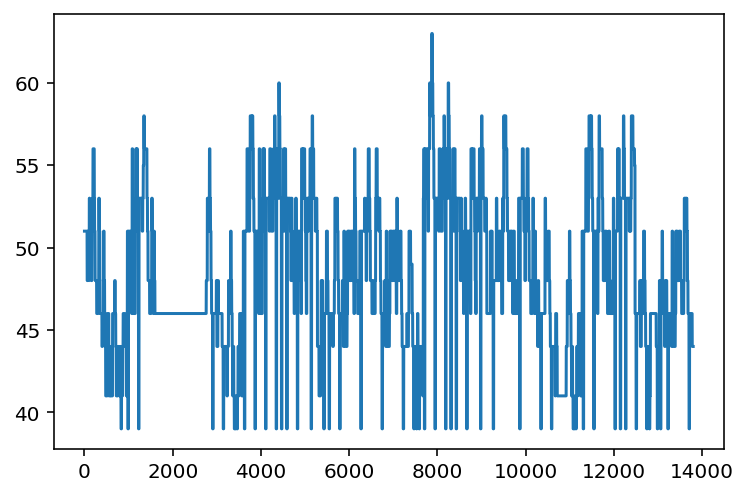

In [13]:
import matplotlib.pyplot as plt
plt.plot(part5.make_pitch_contour())

In [14]:
# part, i = score_set.score.parts[5], 5
# part5 = Part(part, i)
# part5.measure_duration
# print(part5.measures)

# while True:
  entire_beat = part5.measure_duration
  for measure in part5.measures:
    part = score_set.score.parts[5]
# part5 = Part(part, i) 
    current_beat = sum(note.duration for note in measure)
    # print(current_beat, entire_beat)
    if current_beat < entire_beat:
      # print(current_beat, entire_beat)
      # print(measure)
      # print(measure[-1].offset, measure[-1].duration)
      new_note = m21_note.Note(pitch=30, quarterLength=entire_beat - current_beat)
      part.insert(measure[-1].offset+measure[-1].duration, new_note)
      # measure.append(Gnote(m21_note.Note(pitch=30, quarterLength=entire_beat - current_beat, offset=measure[-1].offset+measure[-1].duration), 5))
      print('added!')
      break
  
  # sum_list = [sum(note.duration for note in measure) for measure in part5.measures]
  # if sum(sum_list) == len(part5.measures) * entire_beat:
  #   print("done?")
  #   break
  
# for i, measure in enumerate(part5.measures):
#   current_beat = sum(note.duration for note in measure)
#   entire_beat = part5.measure_duration
#   if current_beat < entire_beat:
#     print(measure)

IndentationError: unexpected indent (1358237589.py, line 7)

In [4]:
whole_score = converter.parse(file_list[0])

by_measure_parse_dic = defaultdict()
for part_idx in range(len(whole_score.parts)):
  part_dic = defaultdict(list)
  for note in whole_score.parts[part_idx].flat.notes:
    if not note.duration.isGrace:
      part_dic[note.measureNumber].append(note)
  by_measure_parse_dic[part_idx] = part_dic


In [171]:
part.measure

<bound method Stream.measure of <music21.stream.Part 韓新>>

In [204]:
print(score_set.parts[5].make_pitch_contour())

115
[51. 51. 51. ... 44. 44. 44.]


In [16]:
contours = [part.make_pitch_contour() for part in score_set.parts]

160
160
160
160
65
115
160
160


In [3]:
import matplotlib.pyplot as plt
import numpy as np

measure_sample = 120
measure_by_contour = [contours[-1][i * measure_sample : (i + 1) * measure_sample] for i in range(160)]

self_similarity_matrix = np.zeros((160, 160))

for i, measure1 in enumerate(measure_by_contour):
    for j, measure2 in enumerate(measure_by_contour):
        similarity = np.sum(measure1 == measure2) / measure_sample  # Calculate similarity
        self_similarity_matrix[i, j] = similarity

plt.figure(figsize=(12, 12))
plt.imshow(self_similarity_matrix, cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Self-Similarity Matrix')
plt.show()


NameError: name 'contours' is not defined

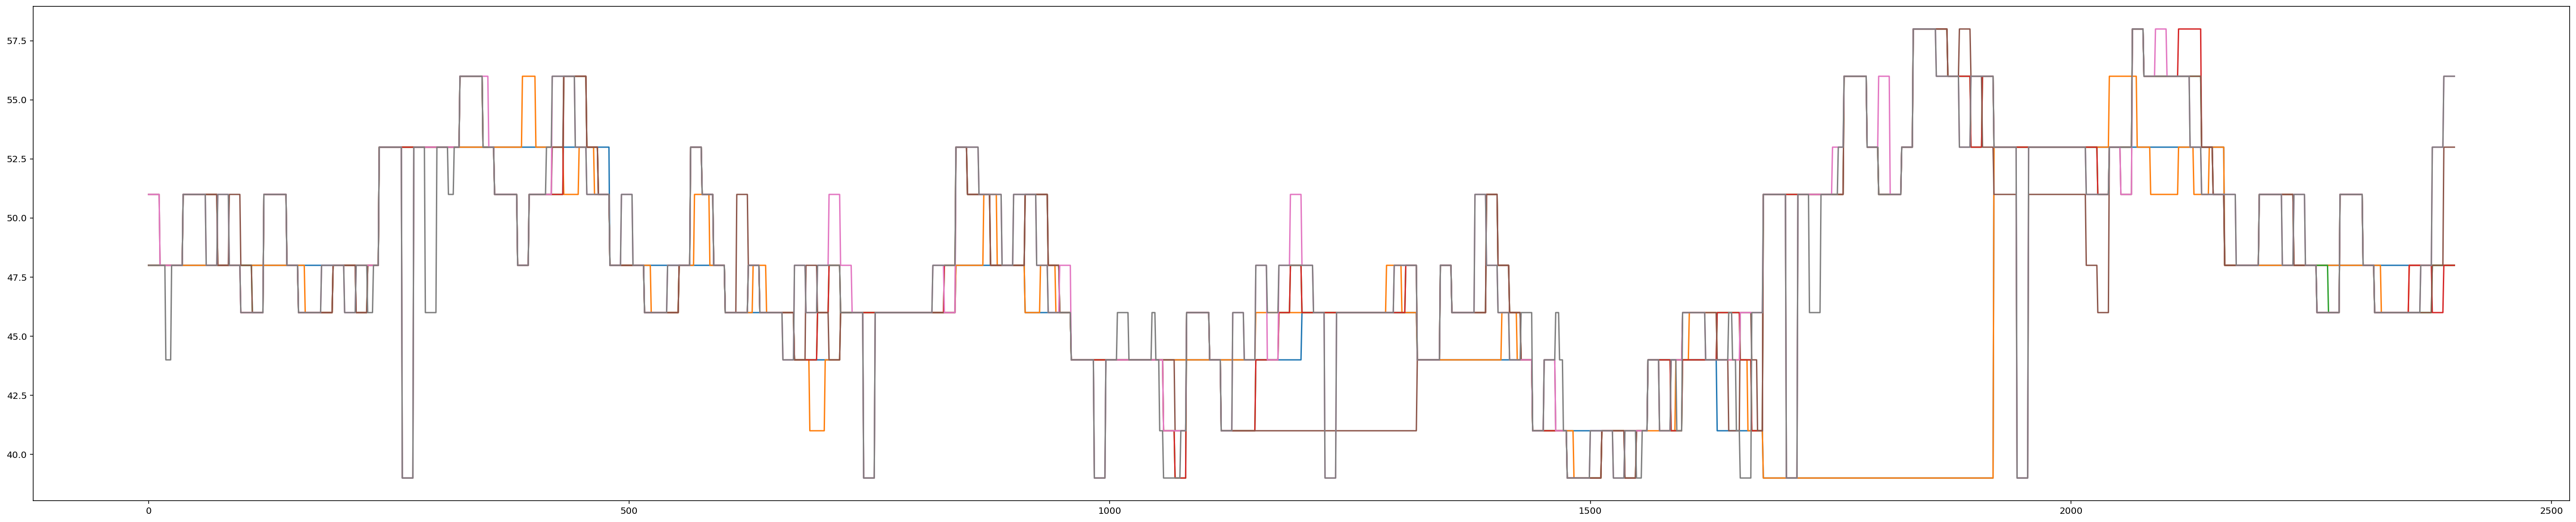

In [20]:
import matplotlib.pyplot as plt

measure_start = 80
measure_end = 100

sampling_rate = 12

start_idx = measure_start * 10 * sampling_rate
end_idx = measure_end * 10 * sampling_rate

plt.figure(figsize = (50, 10))
for contour in contours:
  plt.plot(contour[start_idx:end_idx])


In [8]:
len(score_set.parts[0].measures)

160

In [21]:
12/5

2.4

In [19]:
score_set.parts[-1].measure_duration

10.0

In [15]:
min([note.duration for note in score_set.parts[-3].tie_cleaned_notes])

0.5